Кирилл Лалаянц, R33352

# Лабораторная работа No10
# В -- 11
## Линейно-квадратичные радости

Импорт необходимых для работы библиотек. 

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import control 
import sympy
import os
import scipy
import cvxpy 
import array_to_latex as a2l
# plt.rcParams['text.usetex'] = True

SAVE_PATH = 'tex-report/src/figs/'
os.makedirs(SAVE_PATH, exist_ok=True)
np.set_printoptions(precision=2)
sympy.init_printing()
p = sympy.Symbol("p")
s = sympy.Symbol("s")
t = sympy.Symbol("t")
w = sympy.Symbol("w")
I = sympy.I


def get_t(end_t = 10, dt=0.001, start_t = 0):
    return np.linspace(start_t, end_t, int(end_t / dt))

In [3]:
def get_controllability_matrix(A, B):
    ctrb_m = np.hstack((B, *[(np.linalg.matrix_power(A, i)) @ B for i in range(1, A.shape[0])]))
    assert np.allclose(control.ctrb(A, B), ctrb_m), 'Smth wrong'
    return ctrb_m

def get_observability_matrix(A, C):
    obsv_m = np.vstack((C, *[C @ np.linalg.matrix_power(A, i) for i in range(1, A.shape[0])]))
    assert np.allclose(control.obsv(A, C), obsv_m), 'Smth wrong'
    return obsv_m

def check_controllability(A, B):
    U = get_controllability_matrix(A, B)
    print(f'RankU = {np.linalg.matrix_rank(U)}')
    return np.linalg.matrix_rank(U) == A.shape[0]
        
def check_controllability_eigens(A, B):
    eig_vals = np.linalg.eigvals(A)
    print(f'Eigen values of A:')
    for val in eig_vals:
        print(f"   {np.array([val])}: {'controllable' if np.linalg.matrix_rank(np.hstack(((A - val * np.eye(A.shape[0])), B))) == A.shape[0] else 'not controllable'}")

def check_observability(C, A):
    V = get_observability_matrix(A, C)
    print(f'RankV = {np.linalg.matrix_rank(V)}')
    return np.linalg.matrix_rank(V) == A.shape[0]

def check_observability_eigens(C, A):
    eig_vals = np.linalg.eigvals(A)
    print(f'Eigen values of A:')
    for val in eig_vals:
        print(f"   {np.array([val])}: {'observable' if np.linalg.matrix_rank(np.vstack(((A - val * np.eye(A.shape[0])), C))) == A.shape[0] else 'not observable'}")


In [4]:
A = np.array([
    [-6, 19, 10, -13],
    [0, -9, 0, 6],
    [-4, 8, 6, -7],
    [0, -15, 0, 9]
])

B = np.array([[4, 0], 
                    [2, 0], 
                    [6, 0], 
                    [4, 0]])

C= np.array([[-3, 9, 3, -6], 
                    [0, -2, 0, 1]])

D= np.array([[0, 0], 
                    [0, 2]])

## Task1

In [48]:
task1_x0 = np.ones(A.shape[0]).reshape(-1, 1)
values = np.array([1e-1, 1, 1e1])
dt = 0.001
ts = get_t(15, dt=dt)

======= Q = 0.1; R = 10.0 ===========
K = array([[-0.24,  0.97,  0.51, -0.6 ],
       [ 0.  ,  0.  ,  0.  ,  0.  ]])
P = [[  1.1   -4.78  -1.72   3.25]
 [ -4.78  29.32   8.11 -19.63]
 [ -1.72   8.11   3.07  -5.68]
 [  3.25 -19.63  -5.68  13.57]]
eig(A+BK) = [-0.53+2.1j  -0.53-2.1j  -0.27+2.93j -0.27-2.93j]
J_theory = [[6.2]]
J_real = 6.199532476775565
======= Q = 1.0; R = 1.0 ===========
K = array([[-1.2 , 10.88,  3.57, -6.8 ],
       [ 0.  ,  0.  ,  0.  ,  0.  ]])
P = [[  2.76 -18.96  -4.19  12.71]
 [-18.96 142.76  31.41 -96.83]
 [ -4.19  31.41   7.97 -22.57]
 [ 12.71 -96.83 -22.57  67.86]]
eig(A+BK) = [-0.29+2.68j -0.29-2.68j -3.9 +0.j   -6.7 +0.j  ]
J_theory = [[24.5]]
J_real = 24.518946805046163
======= Q = 10.0; R = 0.1 ===========
K = array([[ -6.23,  99.18,  27.8 , -62.96],
       [  0.  ,   0.  ,   0.  ,   0.  ]])
P = [[  25.51 -177.45  -37.5   119.31]
 [-177.45 1314.86  279.66 -896.99]
 [ -37.5   279.66   68.1  -203.78]
 [ 119.31 -896.99 -203.78  633.29]]
eig(A+BK) = [-84.73+0

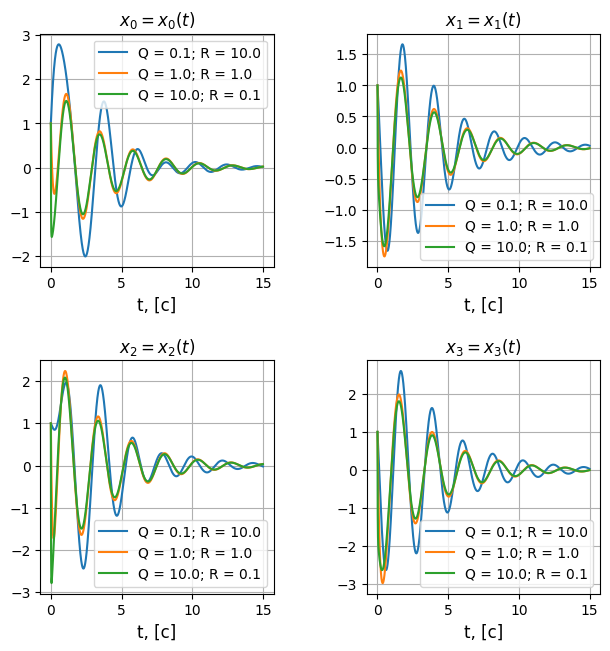

In [49]:
task1_us = []
fig, axs = plt.subplots(2, 2, figsize=(7, 7))
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4,hspace=0.4)

for indx in range(values.shape[0]):
    print(f'======= Q = {values[indx]}; R = {values[::-1][indx]} ===========')
    Q = np.diag(np.ones((A.shape[0]))) * values[indx]
    R = np.diag(np.ones((B.shape[1]))) * values[::-1][indx]
    K, S, E = control.lqr(A, B, Q, R)
    print(f'{K = }')
    print(f'P = {S}')
    print(f'eig(A+BK) = {E}')
    print(f"J_theory = {task1_x0.T @ S @ task1_x0}")
    
    ss = control.ss(A - B@K, A*0, A*0, A*0)
    res = control.forced_response(ss, X0=task1_x0, T=ts)
    
    xs = res.states
    us = - K @ xs
    print(f"J_real = {dt * np.sum(np.diagonal(xs.T @ Q @ xs + us.T @ R @ us))}")
    task1_us.append((us, f'Q = {values[indx]}; R = {values[::-1][indx]}'))
    

    
    for i, state in enumerate(res.states):
        axs[i//2, i%2].plot(ts, state, label=f'Q = {values[indx]}; R = {values[::-1][indx]}') 

for i in range(4):
    axs[i//2, i%2].set_xlabel(f"t, [c]", fontsize=12)
    axs[i//2, i%2].set_title(f"$x_{i} = x_{i}(t)$", fontsize=12)
    axs[i//2, i%2].grid(True)
    axs[i//2, i%2].legend()
plt.savefig(f'{SAVE_PATH}/task1_states.jpg')
    

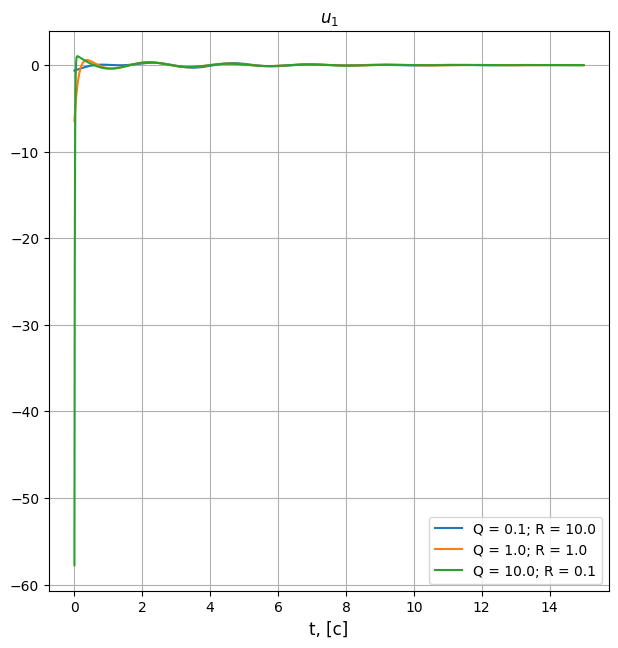

In [50]:
fig, axs = plt.subplots(1, 1, figsize=(7, 7))
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4,hspace=0.4)

for u, l in task1_us:
    plt.plot(ts, u[0], label=l)
    
plt.xlabel(f"t, [c]", fontsize=12)
plt.title(f"$u_1$", fontsize=12)
plt.grid(True)
plt.legend()
plt.savefig(f'{SAVE_PATH}/task1_us.jpg')


## Task2 

In [51]:
def get_K_from_lmi(A, B, alpha):
    P = cvxpy.Variable(A.shape, PSD=True)
    Y = cvxpy.Variable((B.shape[1], B.shape[0]))
    lyapunov_lmi = P @ A.T + A @ P + 2 * alpha * P + Y.T @ B.T + B @ Y
    
    constraints = [P >> np.eye(4) , lyapunov_lmi << 0]
    objective = cvxpy.Minimize(0)
    
    prob = cvxpy.Problem(objective, constraints)
    try:
        print(f'Optimization error: {prob.solve()}')
        print(f'spec(P): {np.linalg.eigvals(P.value)}; P >> 0: {np.all(np.linalg.eigvals(P.value).real >= 0)}')
        print(f'spec(lmi): {np.linalg.eigvals(lyapunov_lmi.value)}; lyapunov_lmi <<= 0: {np.all(np.linalg.eigvals(lyapunov_lmi.value).real <= 0)}')
        # print(P.value)
    except Exception:
        print(':(')
        return 0, False
    
    
    return Y.value @ np.linalg.pinv(P.value), True

In [52]:
K = get_K_from_lmi(A, B, 0)[0]
lmi_ss = control.ss(A + B@K, A*0, A*0, A*0)
print(f'eig(A+BK) = {np.linalg.eigvals(A + B@K)}')
lmi_res = control.forced_response(lmi_ss, X0=task1_x0, T=ts)
xs = lmi_res.states
lmi_us = - K @ xs
print(f"J_lmi = {dt * np.sum(np.diagonal(xs.T @ Q @ xs + lmi_us.T @ R @ lmi_us))}")


Optimization error: 0.0
spec(P): [1.70e+10 1.25e+10 3.13e+08 5.42e+05]; P >> 0: True
spec(lmi): [-4.21e+09 -1.14e+09 -1.09e+06 -1.45e+08]; lyapunov_lmi <<= 0: True
eig(A+BK) = [-161.92+0.j     -0.29+2.63j   -0.29-2.63j   -2.31+0.j  ]
J_lmi = 212.48965547143678


In [53]:
Q = np.diag(np.ones((A.shape[0]))) * values[1]
R = np.diag(np.ones((B.shape[1]))) * values[::-1][1]

K, S, E = control.lqr(A, B, Q, R)
print(f'eig(A+BK) = {E}')
print(f"J_theory = {task1_x0.T @ S @ task1_x0}")

lqr_ss = control.ss(A - B@K, A*0, A*0, A*0)
lqr_res = control.forced_response(lqr_ss, X0=task1_x0, T=ts)

xs = lqr_res.states
lqr_us = - K @ xs
print(f"J_lqr = {dt * np.sum(np.diagonal(xs.T @ Q @ xs + lqr_us.T @ R @ lqr_us))}")


eig(A+BK) = [-0.29+2.68j -0.29-2.68j -3.9 +0.j   -6.7 +0.j  ]
J_theory = [[24.5]]
J_lqr = 24.518946805046163


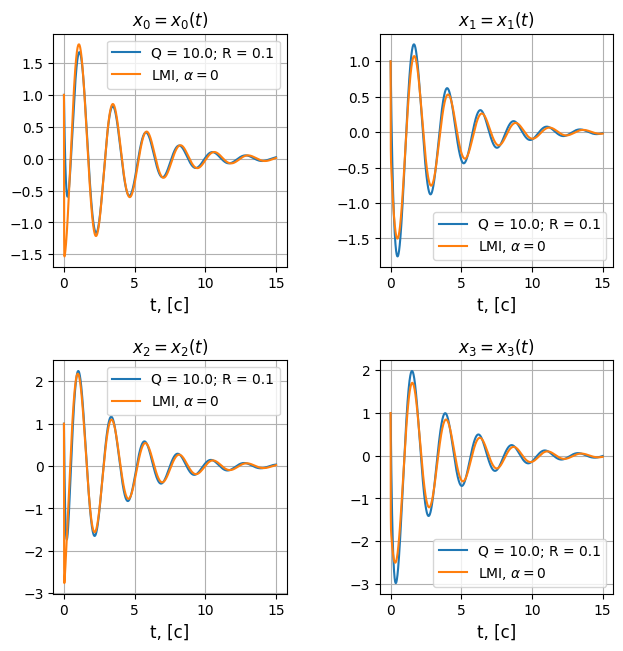

In [54]:
fig, axs = plt.subplots(2, 2, figsize=(7, 7))
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4,hspace=0.4)

for i, state in enumerate(lqr_res.states):
        axs[i//2, i%2].plot(ts, state, label=f'Q = {values[indx]}; R = {values[::-1][indx]}') 
for i, state in enumerate(lmi_res.states):
        axs[i//2, i%2].plot(ts, state, label=f'LMI, $\\alpha = {0}$') 

for i in range(4):
    axs[i//2, i%2].set_xlabel(f"t, [c]", fontsize=12)
    axs[i//2, i%2].set_title(f"$x_{i} = x_{i}(t)$", fontsize=12)
    axs[i//2, i%2].grid(True)
    axs[i//2, i%2].legend()
plt.savefig(f'{SAVE_PATH}/task2_states.jpg')

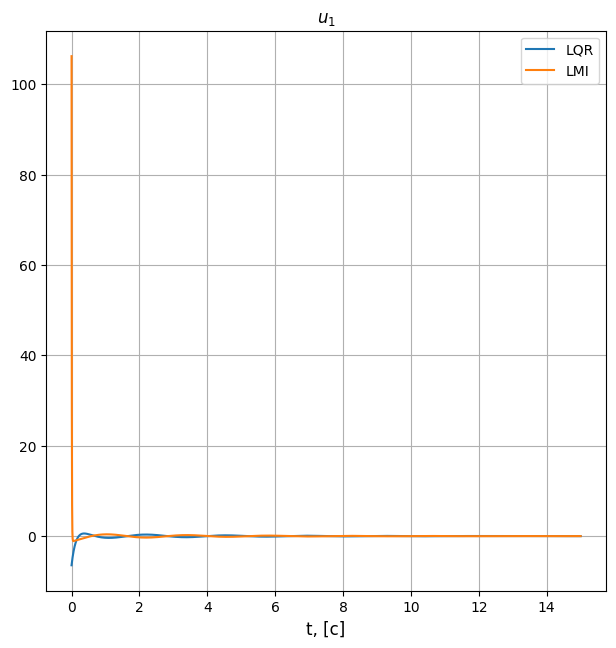

In [56]:
fig, axs = plt.subplots(1, 1, figsize=(7, 7))
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4,hspace=0.4)


plt.plot(ts, lqr_us[0], label='LQR')
plt.plot(ts, lmi_us[0], label='LMI')
    
plt.xlabel(f"t, [c]", fontsize=12)
plt.title(f"$u_1$", fontsize=12)
plt.grid(True)
plt.legend()
plt.savefig(f'{SAVE_PATH}/task2_us.jpg')